# Exploring spin-states of two-particle systems

In [1]:
%reload_ext lab_black

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import complex_ode

from quantum_systems import ODQD, SpatialOrbitalSystem, GeneralOrbitalSystem
from quantum_systems.time_evolution_operators import TimeEvolutionOperator

from configuration_interaction import CISD, TDCISD
from configuration_interaction.ci_helper import state_printer

from gauss_integrator import GaussIntegrator

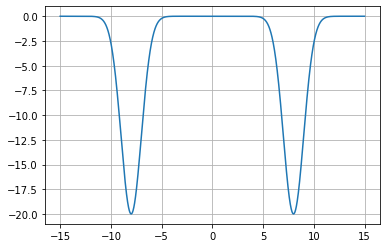

In [3]:
w_l = 20
w_r = 20

center = 8
dev = 1


left_well = ODQD.GaussianPotential(w_l, -center, dev, np)
right_well = ODQD.GaussianPotential(w_r, center, dev, np)

potential = lambda x: left_well(x) + right_well(x)

n = 2
l = 2
soft_coulomb = 1
kappa = 1

grid_length = 15
num_grid_points = 2001
grid = np.linspace(-grid_length, grid_length, num_grid_points)

plt.plot(grid, potential(grid))
plt.grid()

plt.show()

In [4]:
spas = SpatialOrbitalSystem(
    n,
    ODQD(
        l,
        grid_length,
        num_grid_points,
        a=soft_coulomb,
        alpha=kappa,
        potential=potential,
    ),
)

system = spas.construct_general_orbital_system()

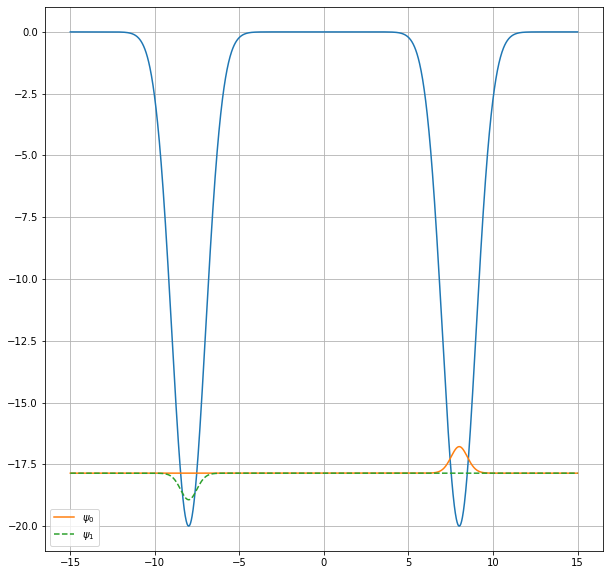

In [5]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, potential(grid))

for i in range(spas.l):
    plt.plot(
        spas.grid,
        spas.spf[i].real + spas.h[i, i].real,
        "-" if i % 2 == 0 else "--",
        label=fr"$\psi_{i}$",
    )

plt.grid()
plt.legend()
plt.show()

[-17.85818828 -17.85818828]


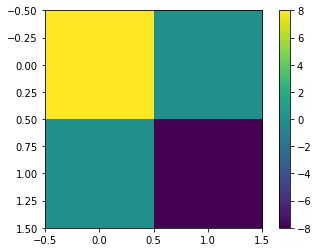

In [6]:
print(np.diag(spas.h.real))

plt.figure()
plt.imshow(spas.dipole_moment[0].real)
plt.colorbar()
plt.show()

In [7]:
cisd = CISD(system, verbose=False).compute_ground_state()

In [8]:
print(cisd.energies)

[-35.6539391  -35.6539391  -35.6539391  -35.6539391  -34.80158235
 -34.80158235]


In [9]:
print(system.h.real)

[[-17.85818828  -0.           0.           0.        ]
 [ -0.         -17.85818828   0.           0.        ]
 [  0.           0.         -17.85818828  -0.        ]
 [  0.           0.          -0.         -17.85818828]]


In [10]:
dets = []

for i, state in enumerate(cisd.states):
    dets.append(f"|{state_printer(state)[56:]}>")
    print(f"|Phi_{i}> = {dets[-1]}")

|Phi_0> = |00000011>
|Phi_1> = |00000101>
|Phi_2> = |00000110>
|Phi_3> = |00001001>
|Phi_4> = |00001010>
|Phi_5> = |00001100>


In [11]:
eigs = []

for i in range(cisd.num_states):
    comb = f"|Psi_{i}> = "
    for j, coeff in enumerate(cisd.C[:, i]):
        if abs(coeff) < 1e-10:
            continue

        comb += f"({coeff}){dets[j]}  +  "

    comb = comb[:-5]
    eigs.append(comb)
    print(comb)
    print(f"\tH|Psi_{i}>  =  {(cisd.energies[i])}|Psi_{i}>")
    print(
        f"\tS_z|Psi_{i}>  =  {(cisd.compute_one_body_expectation_value(system.spin_z, K=i)).real}|Psi_{i}>"
    )
    print(
        f"\tS^2|Psi_{i}>  =  {(cisd.compute_two_body_expectation_value(system.spin_2, K=i)).real}|Psi_{i}>"
    )

|Psi_0> = ((1+0j))|00001010>
	H|Psi_0>  =  -35.653939102160436|Psi_0>
	S_z|Psi_0>  =  -1.0|Psi_0>
	S^2|Psi_0>  =  2.0|Psi_0>
|Psi_1> = ((1+0j))|00000101>
	H|Psi_1>  =  -35.653939102160436|Psi_1>
	S_z|Psi_1>  =  1.0|Psi_1>
	S^2|Psi_1>  =  2.0|Psi_1>
|Psi_2> = ((0.7071067811865475+0j))|00000110>  +  ((-0.7071067811865475+0j))|00001001>
	H|Psi_2>  =  -35.65393910216043|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  0.0|Psi_2>
|Psi_3> = ((0.7071067811865475+0j))|00000110>  +  ((0.7071067811865475+0j))|00001001>
	H|Psi_3>  =  -35.65393910216043|Psi_3>
	S_z|Psi_3>  =  0.0|Psi_3>
	S^2|Psi_3>  =  1.9999999999999996|Psi_3>
|Psi_4> = ((1+0j))|00000011>
	H|Psi_4>  =  -34.80158235344739|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  0.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  -34.80158235344659|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>


$[A, B] = 0 \iff C\psi_i = (A + B)\psi_i = c_i\psi_i = A\psi_i + B\psi_i = a_i\psi_i + b_i\psi_i$

$[A, B] \neq 0 \iff C\psi_i = (A + B)\psi_i = A\psi_i + B\psi_i = c_i\psi_i \neq a_i\psi_i + b_i\psi_i$

## Lowest eigenstates of $\hat{H}$

### With $\kappa = 0$

```
|Psi_0> = ((1+0j))|00000011>
	H|Psi_0>  =  -35.71637656127508|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((1+0j))|00000101>
	H|Psi_1>  =  -35.71637656127468|Psi_1>
	S_z|Psi_1>  =  1.0|Psi_1>
	S^2|Psi_1>  =  2.0|Psi_1>
|Psi_2> = ((1+0j))|00000110>
	H|Psi_2>  =  -35.71637656127468|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  1.0|Psi_2>
|Psi_3> = ((1+0j))|00001001>
	H|Psi_3>  =  -35.71637656127468|Psi_3>
	S_z|Psi_3>  =  0.0|Psi_3>
	S^2|Psi_3>  =  1.0|Psi_3>
|Psi_4> = ((1+0j))|00001010>
	H|Psi_4>  =  -35.71637656127468|Psi_4>
	S_z|Psi_4>  =  -1.0|Psi_4>
	S^2|Psi_4>  =  2.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  -35.71637656127428|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```


### With $\kappa = 1$
```
|Psi_0> = ((1+0j))|00000101>
	H|Psi_0>  =  -35.653939102160436|Psi_0>
	S_z|Psi_0>  =  1.0|Psi_0>
	S^2|Psi_0>  =  2.0|Psi_0>
|Psi_1> = ((1+0j))|00000110>
	H|Psi_1>  =  -35.653939102160436|Psi_1>
	S_z|Psi_1>  =  0.0|Psi_1>
	S^2|Psi_1>  =  1.0|Psi_1>
|Psi_2> = ((1+0j))|00001001>
	H|Psi_2>  =  -35.653939102160436|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  1.0|Psi_2>
|Psi_3> = ((1+0j))|00001010>
	H|Psi_3>  =  -35.653939102160436|Psi_3>
	S_z|Psi_3>  =  -1.0|Psi_3>
	S^2|Psi_3>  =  2.0|Psi_3>
|Psi_4> = ((1+0j))|00000011>
	H|Psi_4>  =  -34.80158235344739|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  0.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  -34.80158235344659|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

## Lowest eigenstates of $\hat{H} + \hat{S}_z + \hat{S}^2$

### With $\kappa = 0$

```
|Psi_0> = ((1+0j))|00000011>
	H|Psi_0>  =  -35.71637656127508|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((1+0j))|00001010>
	H|Psi_1>  =  -35.71637656127468|Psi_1>
	S_z|Psi_1>  =  -1.0|Psi_1>
	S^2|Psi_1>  =  2.0|Psi_1>
|Psi_2> = ((1+0j))|00000101>
	H|Psi_2>  =  -35.71637656127468|Psi_2>
	S_z|Psi_2>  =  1.0|Psi_2>
	S^2|Psi_2>  =  2.0|Psi_2>
|Psi_3> = ((0.7071067811865475+0j))|00000110>  +  ((-0.7071067811865475+0j))|00001001>
	H|Psi_3>  =  -35.71637656127467|Psi_3>
	S_z|Psi_3>  =  0.0|Psi_3>
	S^2|Psi_3>  =  0.0|Psi_3>
|Psi_4> = ((0.7071067811865475+0j))|00000110>  +  ((0.7071067811865475+0j))|00001001>
	H|Psi_4>  =  -35.71637656127467|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  1.9999999999999996|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  -35.71637656127428|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

### With $\kappa = 1$

```
|Psi_0> = ((1+0j))|00001010>
	H|Psi_0>  =  -35.653939102160436|Psi_0>
	S_z|Psi_0>  =  -1.0|Psi_0>
	S^2|Psi_0>  =  2.0|Psi_0>
|Psi_1> = ((1+0j))|00000101>
	H|Psi_1>  =  -35.653939102160436|Psi_1>
	S_z|Psi_1>  =  1.0|Psi_1>
	S^2|Psi_1>  =  2.0|Psi_1>
|Psi_2> = ((0.7071067811865475+0j))|00000110>  +  ((-0.7071067811865475+0j))|00001001>
	H|Psi_2>  =  -35.65393910216043|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  0.0|Psi_2>
|Psi_3> = ((0.7071067811865475+0j))|00000110>  +  ((0.7071067811865475+0j))|00001001>
	H|Psi_3>  =  -35.65393910216043|Psi_3>
	S_z|Psi_3>  =  0.0|Psi_3>
	S^2|Psi_3>  =  1.9999999999999996|Psi_3>
|Psi_4> = ((1+0j))|00000011>
	H|Psi_4>  =  -34.80158235344739|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  0.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  -34.80158235344659|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

E_0 = -35.6539  | <d_0> = -0.00000
	Dipole allowed 0 -> 1: [0j]
	Dipole allowed 0 -> 2: [0j]
	Dipole allowed 0 -> 3: [0j]
	Dipole allowed 0 -> 4: [0j]
	Dipole allowed 0 -> 5: [0j]
E_1 = -35.6539  | <d_1> = -0.00000
	Dipole allowed 1 -> 2: [0j]
	Dipole allowed 1 -> 3: [0j]
	Dipole allowed 1 -> 4: [0j]
	Dipole allowed 1 -> 5: [0j]
E_2 = -35.6539  | <d_2> = -0.00000
	Dipole allowed 2 -> 3: [0j]
	Dipole allowed 2 -> 4: [0j]
	Dipole allowed 2 -> 5: [0j]
E_3 = -35.6539  | <d_3> = -0.00000
	Dipole allowed 3 -> 4: [0j]
	Dipole allowed 3 -> 5: [0j]
E_4 = -34.8016  | <d_4> = 16.00000
	Dipole allowed 4 -> 5: [0j]
E_5 = -34.8016  | <d_5> = -16.00000


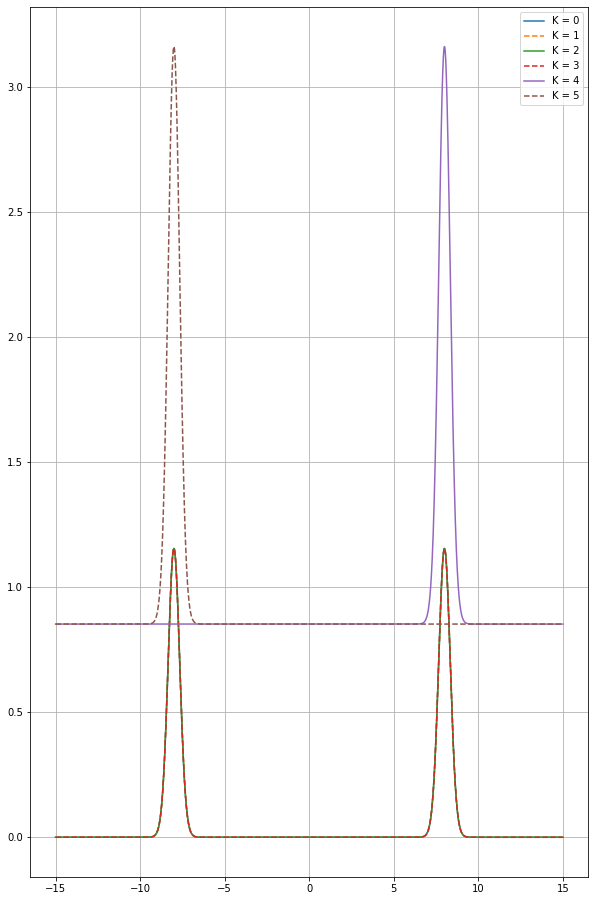

In [12]:
fig = plt.figure(figsize=(10, 16))

for I in range(cisd.num_states):
    dip = cisd.compute_one_body_expectation_value(system.dipole_moment[0], K=I)
    print(fr"E_{I} = {cisd.energies[I]:.4f}  | <d_{I}> = {dip.real:.5f}")
    for J in range(I + 1, cisd.num_states):
        print(f"\tDipole allowed {I} -> {J}: {cisd.allowed_dipole_transition(I, J)}")
    rho_I = cisd.compute_particle_density(K=I).real

    plt.plot(
        system.grid,
        rho_I + cisd.energies[I].real - cisd.energies[0].real,
        "-" if I % 2 == 0 else "--",
        label=fr"K = {I}",
    )
    # print(np.trapz(rho_I, system.grid))

plt.grid()
plt.legend()
plt.show()

# Repeating with a harmonic oscillator

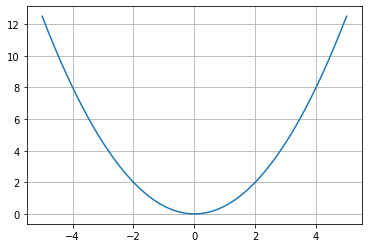

In [13]:
omega = 1

n = 3
l = 3
soft_coulomb = 1
kappa = 1

potential = ODQD.HOPotential(omega=omega)

grid_length = 5
num_grid_points = 2001
grid = np.linspace(-grid_length, grid_length, num_grid_points)

plt.plot(grid, potential(grid))
plt.grid()

plt.show()

In [17]:
system = GeneralOrbitalSystem(
    n,
    ODQD(
        l,
        grid_length,
        num_grid_points,
        a=soft_coulomb,
        alpha=kappa,
        potential=potential,
    ),
)

# system = spas.construct_general_orbital_system()

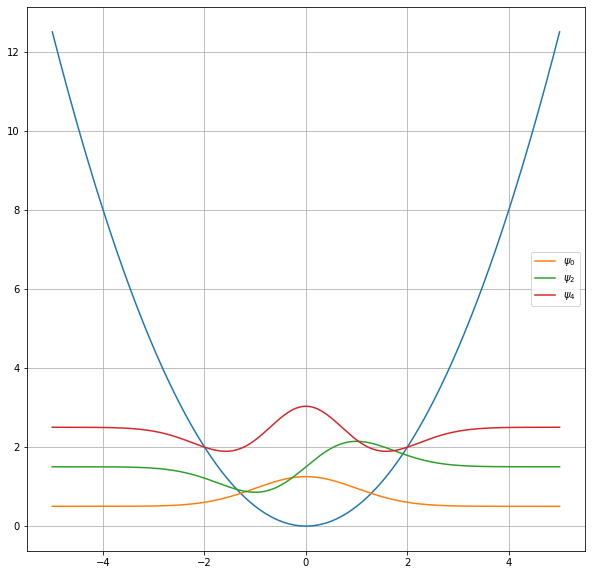

In [20]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, potential(grid))

for i in range(0, system.l, 2):
    plt.plot(
        system.grid,
        system.spf[i].real + system.h[i, i].real,
        "-" if i % 2 == 0 else "--",
        label=fr"$\psi_{i}$",
    )

plt.grid()
plt.legend()
plt.show()

[0.49999922 1.4999961  2.49998993]


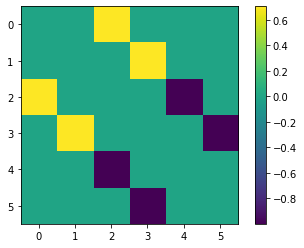

In [22]:
print(np.diag(system.h.real)[::2])

plt.figure()
plt.imshow(system.dipole_moment[0].real)
plt.colorbar()
plt.show()

In [23]:
cisd = CISD(system, verbose=False).compute_ground_state()

In [24]:
print(cisd.energies)

[4.53571895 4.53621824 5.30798154 5.30798154 5.51436602 5.51436602
 6.11038016 6.11038016 6.11038016 6.11038016 6.30686491 6.312659
 6.44321403 6.45036975 7.1523374  7.1523374  7.35854662 7.35854662
 8.17498644]


In [25]:
print(system.h.real)

[[0.49999922 0.         0.         0.         0.         0.        ]
 [0.         0.49999922 0.         0.         0.         0.        ]
 [0.         0.         1.4999961  0.         0.         0.        ]
 [0.         0.         0.         1.4999961  0.         0.        ]
 [0.         0.         0.         0.         2.49998993 0.        ]
 [0.         0.         0.         0.         0.         2.49998993]]


In [26]:
dets = []

for i, state in enumerate(cisd.states):
    dets.append(f"|{state_printer(state)[56:]}>")
    print(f"|Phi_{i}> = {dets[-1]}")

|Phi_0> = |00000111>
|Phi_1> = |00001011>
|Phi_2> = |00001101>
|Phi_3> = |00001110>
|Phi_4> = |00010011>
|Phi_5> = |00010101>
|Phi_6> = |00010110>
|Phi_7> = |00011001>
|Phi_8> = |00011010>
|Phi_9> = |00011100>
|Phi_10> = |00100011>
|Phi_11> = |00100101>
|Phi_12> = |00100110>
|Phi_13> = |00101001>
|Phi_14> = |00101010>
|Phi_15> = |00101100>
|Phi_16> = |00110001>
|Phi_17> = |00110010>
|Phi_18> = |00110100>


In [27]:
eigs = []

for i in range(cisd.num_states):
    comb = f"|Psi_{i}> = "
    for j, coeff in enumerate(cisd.C[:, i]):
        if abs(coeff) < 1e-10:
            continue

        comb += f"({coeff}){dets[j]}  +  "

    comb = comb[:-5]
    eigs.append(comb)
    print(comb)
    print(f"\tH|Psi_{i}>  =  {(cisd.energies[i])}|Psi_{i}>")
    print(
        f"\tS_z|Psi_{i}>  =  {(cisd.compute_one_body_expectation_value(system.spin_z, K=i)).real}|Psi_{i}>"
    )
    print(
        f"\tS^2|Psi_{i}>  =  {(cisd.compute_two_body_expectation_value(system.spin_2, K=i)).real}|Psi_{i}>"
    )

|Psi_0> = ((0.9629890639563823+0j))|00000111>  +  ((-0.21960595927533275+0j))|00010110>  +  ((0.09865139792177934+0j))|00011001>  +  ((0.12095456135355333+0j))|00100101>  +  ((-0.007948655673749493+0j))|00110100>
	H|Psi_0>  =  4.535718947258569|Psi_0>
	S_z|Psi_0>  =  0.5|Psi_0>
	S^2|Psi_0>  =  3.0|Psi_0>
|Psi_1> = ((0.9628829981461735+0j))|00001011>  +  ((-0.12207404559621596+0j))|00011010>  +  ((-0.09787053361236403+0j))|00100110>  +  ((0.21994457920858024+0j))|00101001>
	H|Psi_1>  =  4.536218238610624|Psi_1>
	S_z|Psi_1>  =  -0.4999999999999996|Psi_1>
	S^2|Psi_1>  =  2.9999999999999982|Psi_1>
|Psi_2> = ((0.8245089134074709+0j))|00001110>  +  ((-0.5605361966938697+0j))|00100011>  +  ((-0.02375591868569581+0j))|00101100>  +  ((-0.07361983588002038+0j))|00110010>
	H|Psi_2>  =  5.307981537441375|Psi_2>
	S_z|Psi_2>  =  -0.4999999999999997|Psi_2>
	S^2|Psi_2>  =  2.999999999999998|Psi_2>
|Psi_3> = ((-0.8245089134074547+0j))|00001101>  +  ((0.5605361966938939+0j))|00010011>  +  ((0.0237559186

## Eigenstate of $\hat{H}$

### With $\kappa = 0$

```
|Psi_0> = ((1+0j))|00000011>
	H|Psi_0>  =  0.9999984376530564|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((1+0j))|00000101>
	H|Psi_1>  =  1.9999953162380049|Psi_1>
	S_z|Psi_1>  =  1.0|Psi_1>
	S^2|Psi_1>  =  2.0|Psi_1>
|Psi_2> = ((1+0j))|00000110>
	H|Psi_2>  =  1.9999953162380049|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  1.0|Psi_2>
|Psi_3> = ((1+0j))|00001001>
	H|Psi_3>  =  1.9999953162380049|Psi_3>
	S_z|Psi_3>  =  0.0|Psi_3>
	S^2|Psi_3>  =  1.0|Psi_3>
|Psi_4> = ((1+0j))|00001010>
	H|Psi_4>  =  1.9999953162380049|Psi_4>
	S_z|Psi_4>  =  -1.0|Psi_4>
	S^2|Psi_4>  =  2.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  2.999992194822953|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

### With $\kappa = 1$

```
|Psi_0> = ((0.9981906748064058+0j))|00000011>  +  ((-0.06012800287330437+0j))|00001100>
	H|Psi_0>  =  1.782869665682454|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((0.8220571370545804+0j))|00000101>  +  ((-0.4026301425735701+0j))|00000110>  +  ((-0.40263014257357+0j))|00001001>
	H|Psi_1>  =  2.5648869193008386|Psi_1>
	S_z|Psi_1>  =  0.6757779365823733|Psi_1>
	S^2|Psi_1>  =  1.9999999999999998|Psi_1>
|Psi_2> = ((1+0j))|00001010>
	H|Psi_2>  =  2.564886919300839|Psi_2>
	S_z|Psi_2>  =  -1.0|Psi_2>
	S^2|Psi_2>  =  2.0|Psi_2>
|Psi_3> = ((0.5694050082477563+0j))|00000101>  +  ((0.5812821761340933+0j))|00000110>  +  ((0.5812821761340929+0j))|00001001>
	H|Psi_3>  =  2.564886919300842|Psi_3>
	S_z|Psi_3>  =  0.3242220634176275|Psi_3>
	S^2|Psi_3>  =  2.0000000000000027|Psi_3>
|Psi_4> = ((-0.7071067811865472+0j))|00000110>  +  ((0.7071067811865476+0j))|00001001>
	H|Psi_4>  =  2.7896360037896275|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  5.551115123125783e-17|Psi_4>
|Psi_5> = ((-0.06012800287330437+0j))|00000011>  +  ((-0.9981906748064058+0j))|00001100>
	H|Psi_5>  =  3.6551791969769414|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

## Eigenstates of $\hat{H} + \hat{S}_z + \hat{S}^2$

### With $\kappa = 0$

```
|Psi_0> = ((1+0j))|00000011>
	H|Psi_0>  =  0.9999984376530564|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((-0.7071067811865475+0j))|00000110>  +  ((0.7071067811865475+0j))|00001001>
	H|Psi_1>  =  1.9999953162380046|Psi_1>
	S_z|Psi_1>  =  0.0|Psi_1>
	S^2|Psi_1>  =  0.0|Psi_1>
|Psi_2> = ((0.7071067811865475+0j))|00000110>  +  ((0.7071067811865475+0j))|00001001>
	H|Psi_2>  =  1.9999953162380046|Psi_2>
	S_z|Psi_2>  =  0.0|Psi_2>
	S^2|Psi_2>  =  1.9999999999999996|Psi_2>
|Psi_3> = ((1+0j))|00001010>
	H|Psi_3>  =  1.9999953162380049|Psi_3>
	S_z|Psi_3>  =  -1.0|Psi_3>
	S^2|Psi_3>  =  2.0|Psi_3>
|Psi_4> = ((1+0j))|00000101>
	H|Psi_4>  =  1.9999953162380049|Psi_4>
	S_z|Psi_4>  =  1.0|Psi_4>
	S^2|Psi_4>  =  2.0|Psi_4>
|Psi_5> = ((1+0j))|00001100>
	H|Psi_5>  =  2.999992194822953|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  0.0|Psi_5>
```

### With $\kappa = 1$

```
|Psi_0> = ((0.9981906748064058+0j))|00000011>  +  ((-0.06012800287330437+0j))|00001100>
	H|Psi_0>  =  1.782869665682454|Psi_0>
	S_z|Psi_0>  =  0.0|Psi_0>
	S^2|Psi_0>  =  0.0|Psi_0>
|Psi_1> = ((0.7071067811865468+0j))|00000110>  +  ((0.7071067811865479+0j))|00001001>
	H|Psi_1>  =  2.5648869193008377|Psi_1>
	S_z|Psi_1>  =  0.0|Psi_1>
	S^2|Psi_1>  =  1.9999999999999991|Psi_1>
|Psi_2> = ((-0.9999999999999998+0j))|00000101>
	H|Psi_2>  =  2.564886919300838|Psi_2>
	S_z|Psi_2>  =  0.9999999999999996|Psi_2>
	S^2|Psi_2>  =  1.9999999999999991|Psi_2>
|Psi_3> = ((1+0j))|00001010>
	H|Psi_3>  =  2.564886919300839|Psi_3>
	S_z|Psi_3>  =  -1.0|Psi_3>
	S^2|Psi_3>  =  2.0|Psi_3>
|Psi_4> = ((-0.7071067811865477+0j))|00000110>  +  ((0.707106781186547+0j))|00001001>
	H|Psi_4>  =  2.789636003789627|Psi_4>
	S_z|Psi_4>  =  0.0|Psi_4>
	S^2|Psi_4>  =  -5.551115123125783e-17|Psi_4>
|Psi_5> = ((-0.06012800287330437+0j))|00000011>  +  ((-0.9981906748064058+0j))|00001100>
	H|Psi_5>  =  3.6551791969769414|Psi_5>
	S_z|Psi_5>  =  0.0|Psi_5>
	S^2|Psi_5>  =  -8.96831017167883e-44|Psi_5>
```

E_0 = 4.5357  | <d_0> = 0.00000
	Dipole allowed 0 -> 1: [(4.364120425176858e-16+0j)]
	Dipole allowed 0 -> 2: [(2.3738327539109e-15+0j)]
	Dipole allowed 0 -> 3: [(0.1692830460862672+0j)]
	Dipole allowed 0 -> 4: [(-8.458699975841089e-15+0j)]
	Dipole allowed 0 -> 5: [(1.0222092329824166+0j)]
	Dipole allowed 0 -> 6: [(9.456322501109524e-17+0j)]
	Dipole allowed 0 -> 7: [(-4.258537685798123e-18+0j)]
	Dipole allowed 0 -> 8: [(1.2699440555359772e-16+0j)]
	Dipole allowed 0 -> 9: [(5.928699147126989e-17+0j)]
	Dipole allowed 0 -> 10: [(4.582575039136268e-13+0j)]
	Dipole allowed 0 -> 11: [(-1.612068654361536e-15+0j)]
	Dipole allowed 0 -> 12: [(9.858469123030691e-13+0j)]
	Dipole allowed 0 -> 13: [(-1.1567879385483423e-15+0j)]
	Dipole allowed 0 -> 14: [(-0.10392199396138271+0j)]
	Dipole allowed 0 -> 15: [(-5.244642170755751e-16+0j)]
	Dipole allowed 0 -> 16: [(-8.800648287252545e-15+0j)]
	Dipole allowed 0 -> 17: [(0.051445880706831364+0j)]
	Dipole allowed 0 -> 18: [(-6.675075409036308e-14+0j)]
	(int)

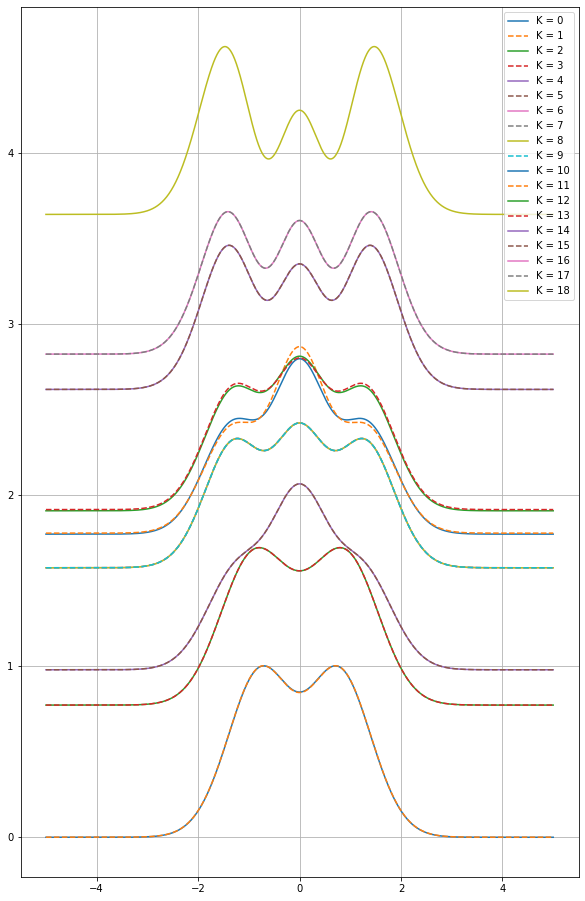

In [28]:
fig = plt.figure(figsize=(10, 16))

for I in range(cisd.num_states):
    dip = cisd.compute_one_body_expectation_value(system.dipole_moment[0], K=I)
    print(fr"E_{I} = {cisd.energies[I]:.4f}  | <d_{I}> = {dip.real:.5f}")
    for J in range(I + 1, cisd.num_states):
        print(f"\tDipole allowed {I} -> {J}: {cisd.allowed_dipole_transition(I, J)}")
    rho_I = cisd.compute_particle_density(K=I).real

    plt.plot(
        system.grid,
        rho_I + cisd.energies[I].real - cisd.energies[0].real,
        "-" if I % 2 == 0 else "--",
        label=fr"K = {I}",
    )
    print(f"\t(int) dx rho_{I}(x) = {np.trapz(rho_I, system.grid)}")

plt.grid()
plt.legend()
plt.show()